In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import mean_squared_error
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurveExtractor, merge_curves
from lcdb.analysis.json import QueryPreprocessorResults, QueryFittimes

def extract_learner_fit_info(data):
    info = []
    num_feature_list = []
    for fit in data:
        # last time for fitting
        fit_timestamp_stop = fit.get('timestamp_stop')

        # last time for data transform
        children = fit.get('children', [])
        if children and isinstance(children, list):
            last_child = children[-1]
            last_child_timestamp_stop = last_child.get('timestamp_stop', None)
        else:
            last_child_timestamp_stop = None

        # diff (fit_timestamp_stop - last_child_timestamp_stop)
        if fit_timestamp_stop is not None and last_child_timestamp_stop is not None:
            delta_time = fit_timestamp_stop - last_child_timestamp_stop
        else:
            delta_time = None

        # anchor and num of feature
        new_shape = None
        rows = None
        cols = None
        for child in children:
            if child.get('tag') == 'transform_train':
                for grandchild in child.get('children', []):
                    if grandchild.get('tag') == 'pre_numeric_pp':
                        new_shape = grandchild.get('metadata', {}).get('new_shape')
                        if new_shape:
                            rows = new_shape.get('rows')
                            cols = new_shape.get('cols')
                        break 
        num_feature_list.append(cols)
        if len(set(num_feature_list)) == 1: # check all the num_feature the same
            num_feature = num_feature_list[0]
        info.append((delta_time, rows))
        # fit time, anchor, number of feature
    return info, num_feature


In [4]:
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

openmlid = 11    # 3,6,11,12,14
workflow = workflows[0]

# retrieve learning curve objects
lcdb = LCDB()
df = lcdb.query(
    openmlids=[openmlid],
    workflows=[workflow],
    return_generator=False,
    show_progress=True
)

print(f"df shape: {df.shape}")

100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

df shape: (25690, 31)


In [14]:
def extract_train_transform_info(data):
    info = []
    num_feature_list = []
    for i in data:
        # preprocessing time
        timestamp_stop = i[0].get('timestamp_stop')
        timestamp_start = i[0].get('timestamp_start')
        preprocessing_time = timestamp_stop - timestamp_start if timestamp_start and timestamp_stop else None

        # Extract row and column information from metadata
        new_shape = i[0].get('metadata', {}).get('new_shape', {})
        rows = new_shape.get('rows')
        cols = new_shape.get('cols')

        num_feature_list.append(cols)
        if len(set(num_feature_list)) == 1: # check all the num_feature the same
            num_feature = num_feature_list[0]
        info.append((preprocessing_time, rows))
        # train data preprocessing time, anchor, number of feature
    return info, num_feature


In [13]:
i.get('timestamp_stop')

AttributeError: 'list' object has no attribute 'get'

In [10]:
for i in extracted_data:
    print(i)

[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.4683, 'timestamp_stop': 1.4694, 'metadata': {'new_shape': {'rows': 16, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.5258, 'timestamp_stop': 1.5264, 'metadata': {'new_shape': {'rows': 23, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.5772, 'timestamp_stop': 1.5778, 'metadata': {'new_shape': {'rows': 32, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.6292, 'timestamp_stop': 1.6298, 'metadata': {'new_shape': {'rows': 45, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.6809, 'timestamp_stop': 1.6815, 'metadata': {'new_shape': {'rows': 64, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.733, 'timestamp_stop': 1.7335, 'metadata': {'new_shape': {'rows': 91, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.7856, 'timestamp_stop': 1.7861, 'metadata': {'new_shape': {'rows': 128, 'cols': 4}}}]
[{'tag': 'pre_numeric_pp', 'timestamp_start': 1.8387, 'timestamp_stop

### Query preprocessing time and plot

In [18]:
train_transform_columns = []
num_feature_columns = []
for index, row in tqdm(df.iterrows()): 
    ###### compute the runtime and extract the anchor_value
    extracted_data = QueryPreprocessorResults()(row['m:json'])

    train_transform_info, num_feature_transform = extract_train_transform_info(extracted_data)
    train_transform_columns.append(train_transform_info)
    num_feature_columns.append(num_feature_transform)
df['train_transform_info'] = train_transform_columns
df['transform_num_feature'] = num_feature_columns
transformtime_df = df.drop(columns=['m:json', 'm:timestamp_gather'])

25690it [00:04, 5590.86it/s]


In [25]:
plot_df = transformtime_df[['train_transform_info']]

mean_std_dict = {}
for idx, group in plot_df.groupby(plot_df.index):
    # extract all the fittime_info lists for the current group
    pptime_info_group = group['train_transform_info'].tolist()
    
    # convert into curves in anchors
    pptime_info_array = np.array([np.array(pptime_info)[:, 0] for pptime_info in pptime_info_group])
    anchor = np.array(pptime_info_group[0])[:, 1]  # Use the first row to get the step values
    
    # mean and std
    mean_values = np.mean(pptime_info_array, axis=0)
    std_values = np.std(pptime_info_array, axis=0)
    
    # for plotting
    mean_std_dict[idx] = (anchor, mean_values, std_values)


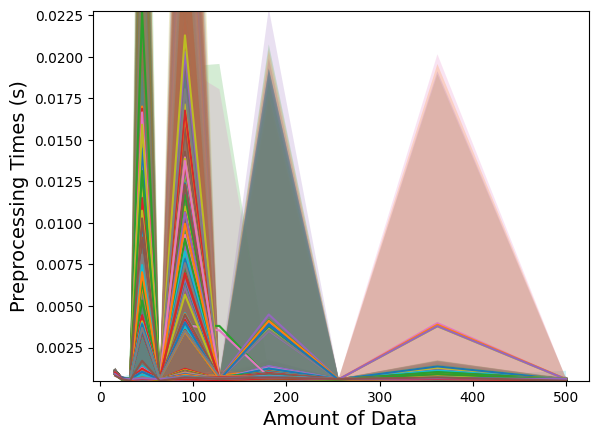

In [26]:
# plot ylim in mean_min and mean_max
all_means = np.concatenate([mean_values for _, (anchor, mean_values, _) in mean_std_dict.items()])
y_min, y_max = np.min(all_means), np.max(all_means)

plt.figure()
for idx, (anchor, mean_values, std_values) in mean_std_dict.items():
    plt.plot(anchor, mean_values, label=f'Index {idx}')
    plt.fill_between(anchor, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.xlabel('Amount of Data', fontsize = 14)
plt.ylabel('Preprocessing Times (s)', fontsize = 14)
plt.ylim([y_min, y_max])
# plt.title(f'{workflow}', fontsize = 14)
plt.show()


### Query learner fitting time and plot

In [21]:
fittime_columns = []
num_feature_columns = []
for index, row in tqdm(df.iterrows()): 
    ###### compute the runtime and extract the anchor_value
    extracted_data = QueryFittimes()(row['m:json'])
    fittime_info, num_feature_transform = extract_learner_fit_info(extracted_data)
    fittime_columns.append(fittime_info)
    num_feature_columns.append(num_feature_transform)
df['fittime_info'] = fittime_columns
df['transform_num_feature'] = num_feature_columns
runtime_df = df.drop(columns=['m:json', 'm:timestamp_gather'])

25690it [00:03, 7864.71it/s]


The dataframe indices correspond to the settings of the hyperparameters

In [27]:
plot_df = runtime_df[['fittime_info']]

mean_std_dict = {}
for idx, group in plot_df.groupby(plot_df.index):
    # extract all the fittime_info lists for the current group
    fittime_info_group = group['fittime_info'].tolist()
    
    # convert into curves in anchors
    fittime_info_array = np.array([np.array(fittime_info)[:, 0] for fittime_info in fittime_info_group])
    anchor = np.array(fittime_info_group[0])[:, 1]  # Use the first row to get the step values
    
    # mean and std
    mean_values = np.mean(fittime_info_array, axis=0)
    std_values = np.std(fittime_info_array, axis=0)
    
    # for plotting
    mean_std_dict[idx] = (anchor, mean_values, std_values)


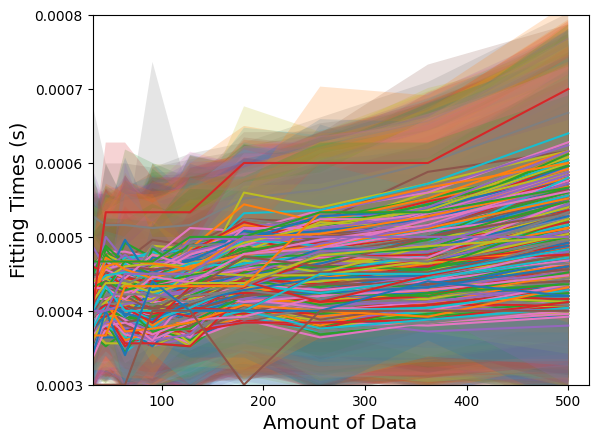

In [38]:
# plot ylim in mean_min and mean_max
all_means = np.concatenate([mean_values for _, (anchor, mean_values, _) in mean_std_dict.items()])
y_min, y_max = np.min(all_means), np.max(all_means)

plt.figure()
for idx, (anchor, mean_values, std_values) in mean_std_dict.items():
    plt.plot(anchor, mean_values, label=f'Index {idx}')
    plt.fill_between(anchor, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.xlabel('Amount of Data', fontsize = 14)
plt.ylabel('Fitting Times (s)', fontsize = 14)
plt.ylim([0.0003, 0.0008])
plt.xlim([32, 520])
# plt.title(f'{workflow}', fontsize = 14)
plt.show()
